In [35]:
import os
import sys
import numpy as np
import warnings
import pandas as pd
import matplotlib
from scipy import special
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

root_path = root_path = os.path.realpath('../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from auto_causality import AutoCausality
from auto_causality.data_utils import preprocess_dataset
from auto_causality.scoring import Scorer

warnings.filterwarnings("ignore")

## Data Generation Process

Here we use a data generation process implemented by EconML for IV models and described as follows:

We construct the DGP as below. The instrument corresponds to a fully randomized recommendation of treatment. Then each sample complies with the recommendation to some degree. This probability depends on both the observed feature $X$ and an unobserved confounder that has a direct effect on the outcome


\begin{align}
W \sim \; & \text{Normal}(0,\, I_{n_w})   \tag{Observed confounders}\\
Z \sim \; & \text{Bernoulli}(p=0.5)   \tag{Instrument}\\
\nu \sim \; & \text{U}[0, 5] \tag{Unobserved confounder}\\
C \sim \; & \text{Bernoulli}(p=0.8 \cdot \text{Sigmoid}(0.4 \cdot X[0] + \nu))   \tag{Compliers when recommended}\\
C0 \sim \; & \text{Bernoulli}(p=0.006)   \tag{Non-Compliers when not recommended}\\
T = \; & C \cdot Z + C0 \cdot (1-Z)  \tag{Treatment}\\
y \sim \; & \theta \cdot T + 2 \cdot \nu + 5 \cdot (X[3]>0) + 0.1 \cdot \text{U}[0, 1]  \tag{Outcome}
\end{align}


In [46]:
def iv_dgp_econml(n=5000, p=10, true_effect=10):

    X = np.random.normal(0, 1, size=(n, p))
    Z = np.random.binomial(1, 0.5, size=(n,))
    nu = np.random.uniform(0, 5, size=(n,))
    coef_Z = 0.8
    C = np.random.binomial(
        1, coef_Z * special.expit(0.4 * X[:, 0] + nu)
    )  # Compliers when recomended
    C0 = np.random.binomial(
        1, 0.006 * np.ones(X.shape[0])
    )  # Non-compliers when not recommended
    T = C * Z + C0 * (1 - Z)
    y = (
        true_effect(X) * T
        + 2 * nu
        + 5 * (X[:, 3] > 0)
        + 2.5 * np.random.uniform(0, 1, size=(n,))
    )
    cov = [f"x{i}" for i in range(1, X.shape[1] + 1)]
    df = pd.DataFrame(X, columns=cov)

    df["y"] = y
    df["treatment"] = T
    df["Z"] = Z

    return df

In [47]:
# Dataset parameters
treatment = "treatment"
targets = ["y"]
instruments = ["Z"]
outcome = targets[0]

For each treatment effect example, we fit a list of 6 IV models, scoring them with an energy distance score. The dataset is split into train, validation and a hold-out test set, and we report scores for each.

As a baseline we use dowhy's simple IV estimator, implementing Ward's estimator and two-stage least squares (2SLS)
The other estimators are implemented by EconML with details [here](https://econml.azurewebsites.net/reference.html#instrumental-variable-cate-estimators)

The components time budget represent tuning budget allocated to each estimator model.

In [39]:
estimator_list = ["SimpleIV", "SparseLinearDRIV", "DMLIV", "OrthoIV", "LinearDRIV", "LinearIntentToTreatDRIV", "ForestDRIV", "IntentToTreatDRIV"]

 We get the estimated effect for the best estimator by energy distance score

In [40]:
# score all estimators on the test set
def score_all_test(models, test_set):
    for est_name, scr in models.scores.items():
        try:
            causal_estimate = scr['estimator']
            # print(causal_estimate.estimator._treatment_name)
            scr['scores']['test'] = models.scorer.make_scores(
                causal_estimate,
                test_set,
                problem=models.problem,
                metrics_to_report=models.metrics_to_report
            )
        except Exception as e:
            print(e)
            pass


def ate_mse(scores, true_effect=TRUE_EFFECT):
    return  [(v-true_effect)**2 for v in scores]


In [63]:
def get_est_effects(models, test_x, te=TRUE_EFFECT):
    est_scores = []
    for est_name, scr in models.scores.items():
        est_effect = scr["estimator"].estimator.effect(test_x).mean()
        energy_distance = scr["scores"]["test"]["energy_distance"]
        est_scores.append([est_name, est_effect, (est_effect-te)**2, energy_distance])

    return pd.DataFrame(est_scores, columns=["estimator", "estimated_effect", "ate_mse", "energy_distance"])


In [42]:
%matplotlib inline

def graph_compare_estimators(model):
    colors = ([matplotlib.colors.CSS4_COLORS['black']] +
        list(matplotlib.colors.TABLEAU_COLORS) + [
        matplotlib.colors.CSS4_COLORS['lime'],
        matplotlib.colors.CSS4_COLORS['yellow'],
        matplotlib.colors.CSS4_COLORS['pink']
    ])


    plt.figure(figsize = (7,5))
    plt.title(outcome)

    m1 = "energy_distance"
    m2 = "ate"

    splits =  ["train", "validation", "test"]

    for (est, scr), col in zip(model.scores.items(), colors):
        try:
            scores  = scr["scores"]
            sc = [scores[v][m1] for v in splits]
            crv = ate_mse([scores[v][m2] for v in splits])
            plt.plot(sc, crv, color=col, marker="o", label=est)
            plt.scatter(sc[1:2],crv[1:2], c=col, s=70, label="_nolegend_" )
            plt.scatter(sc[2:],crv[2:], c=col, s=120, label="_nolegend_" )

        except Exception as e:
            print(e)
            pass

    plt.xlabel(m1)
    plt.ylabel(f"{m2}_MSE")
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

    plt.grid()
    plt.show()


### Model Fitting (2): Heterogeneous Treatment Effect

Here we replace the constant treatment effect with a linear treatment effect function of some covariates  to estimate heterogeneous effects.

\begin{align}
\theta = \; & 6.7  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}

In [ ]:
TRUE_EFFECT = 6.7

In [51]:
NON_LINEAR_EFFECT = lambda X: TRUE_EFFECT * (X[:, 0] ** 2) * (X[:, 1])

synth_data = iv_dgp_econml(n=60000, p=15, true_effect=NON_LINEAR_EFFECT)
data_df, features_X, features_W = preprocess_dataset(
    synth_data, treatment, targets, instruments
)
df_train, df_test = train_test_split(data_df, test_size=0.3)

Xtest = data_df[features_X[0:2]]
df_train.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,random
16419,0.0,9.238960,1.0,1.067054,0.714385,-0.352962,-1.158768,-0.366009,0.165191,-2.107107,-1.751100,0.838383,2.028967,0.0
8558,1.0,13.442729,1.0,-3.575646,1.107023,-1.105476,-1.156808,-1.305229,-1.595064,1.596803,-1.171648,-1.009889,-1.612392,0.0
425,0.0,6.070279,0.0,0.418005,-1.346856,2.028741,-0.238332,0.991197,0.588821,-1.832830,0.729557,-0.422247,0.595469,1.0
14858,1.0,15.816544,1.0,0.748353,0.364992,0.833615,1.243441,1.502731,0.147918,1.168043,0.354507,0.364360,0.892047,1.0
22689,0.0,7.796337,0.0,-1.059137,1.306717,1.245507,-0.749604,-0.860559,0.296209,1.565199,0.059622,-1.465361,-0.068036,1.0


In [53]:
ac_linear_te = AutoCausality(
    estimator_list=["SimpleIV", "SparseLinearDRIV", "DMLIV", "OrthoIV", "LinearDRIV", "LinearIntentToTreatDRIV", "ForestDRIV", "IntentToTreatDRIV"],
    verbose=3,
    components_verbose=2,
    time_budget=28800,
    components_time_budget=1200,
    propensity_model="auto",
    train_size=0.8
)

ac_linear_te.fit(df_train, treatment, outcome, features_X[2:], features_X[:2], instruments)

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks


[flaml.tune.tune: 09-26 13:44:47] {375} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 09-26 13:44:47] {506} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}


Initial configs: [{'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.IntentToTreatDRIV', 'opt_reweighted': 0, 'cov_clip': 0.1, 'prel_opt_reweighted': 1, 'prel_cate_approach': 'driv'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.ForestDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1, 'min_samples_split': 2}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
[flaml.tune.tune: 09-26 13:45:11] {118} INFO - result: {'energy_distance': 0.22867408617253382, 'estimator_name': 'iv.auto_causality.models.SimpleIV', 'scores': {'train': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x169816820>, 'ate': 0.12512341141700745, 'ate_std': 0.0, 'energy_distance': 0.193058835931172}, 'validation': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x16b5fc0d0>, 'ate': 0.12512341141700745, 'ate_std': 0.0, 'energy_distance': 0.22867408617253382}}, 'config'

In [161]:
def get_scores(results_dict, te=TRUE_EFFECT):
    all_scores = list()
    for label, scores in results_dict.items():
        val_scores = scores["scores"]["validation"]
        ate = val_scores["ate"]
        energy_distance = val_scores["energy_distance"]
        all_scores.append([energy_distance, (te-ate)**2])
    return all_scores


def all_estimator_scatter(results, best_estimators, title):
    all_scores = get_scores(results)
    best_scores = get_scores(best_estimators)
    estimators = list(best_estimators.keys())

    fig, ax = plt.subplots(figsize=(9, 7))
    
    for est in all_scores:
        ax.scatter(est[1], est[0], c="gray", label="_nolegend_")
    for i, est in enumerate(best_scores):
        ax.scatter(est[1], est[0], label=estimators[i])
    
    ax.set_ylabel("test score")
    ax.set_xlabel("MSE")
    ax.set_title("energy_distance")
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
    plt.show()

Here, we compare the best run(s) - orange dots - for the selected estimator(s), compared with intermediate runs - grey dots.

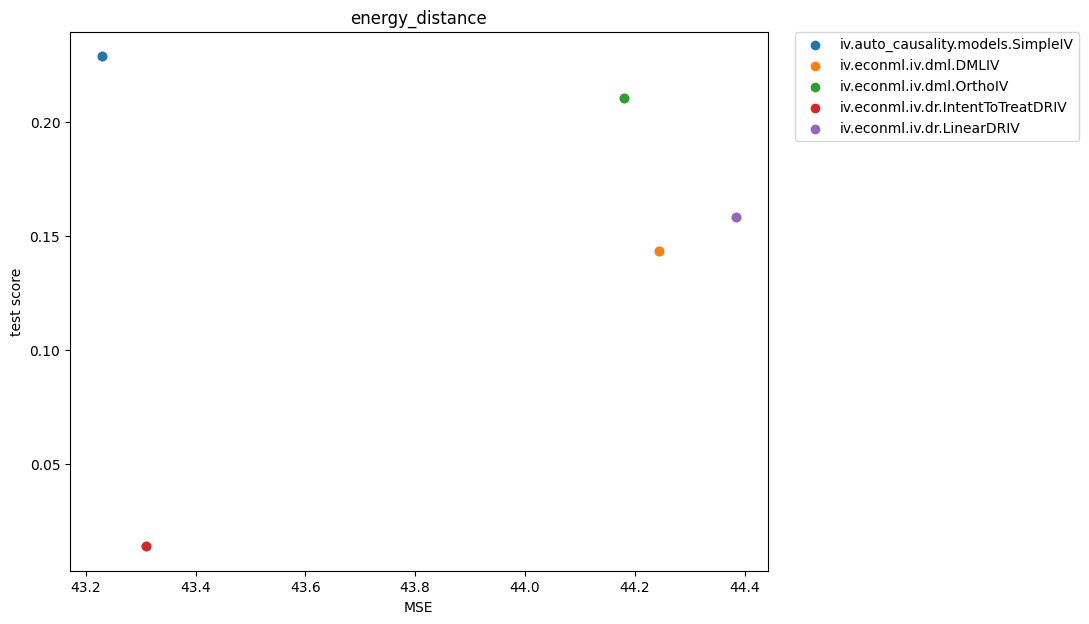

In [162]:
all_estimator_scatter(
    ac_linear_te.results.results,
    ac_linear_te.scores,
    title="linear_cate"
)

In [163]:
import numpy as np

def mse_heffects(estimator, test_cov, labels):
    est_effect = estimator.effect(test_cov)
    mse = np.square(est_effect - labels).mean()
    
    return mse

In [139]:
df_test[['x1', 'x2']].values.shape

CATE_VALUES = lambda x, y: TRUE_EFFECT * (x ** 2) * y
test_covals = df_test[['x1', 'x2']].values
x, y = test_covals[:, 0], test_covals[:, 1]

cate_effect_vals = CATE_VALUES(x, y)

In [164]:
stats = []
for est_name, scr in ac_linear_te.scores.items():
    print(est_name)
    estimator = scr["estimator"].estimator
    
    mse_test = mse_heffects(estimator, df_test[features_X[:2]], cate_effect_vals)

    energy_distance = ac_linear_te.scorer.make_scores(
                scr["estimator"],
                df_test,
                problem=ac_linear_te.problem,
                metrics_to_report=ac_linear_te.metrics_to_report
            )["energy_distance"]
    

    stats.append([est_name, mse_test, energy_distance])
   

In [117]:
get_est_effects(ac_linear_te, df_test[features_X[:2]])

,estimator,estimated_effect,ate_mse,energy_distance
0,iv.auto_causality.models.SimpleIV,0.125123,43.229002,0.208813
1,iv.econml.iv.dml.DMLIV,0.031996,44.462276,0.130863
2,iv.econml.iv.dml.OrthoIV,0.017911,44.650307,0.199842
3,iv.econml.iv.dr.IntentToTreatDRIV,0.024849,44.557638,0.011017
4,iv.econml.iv.dr.LinearDRIV,0.012671,44.720370,0.148137


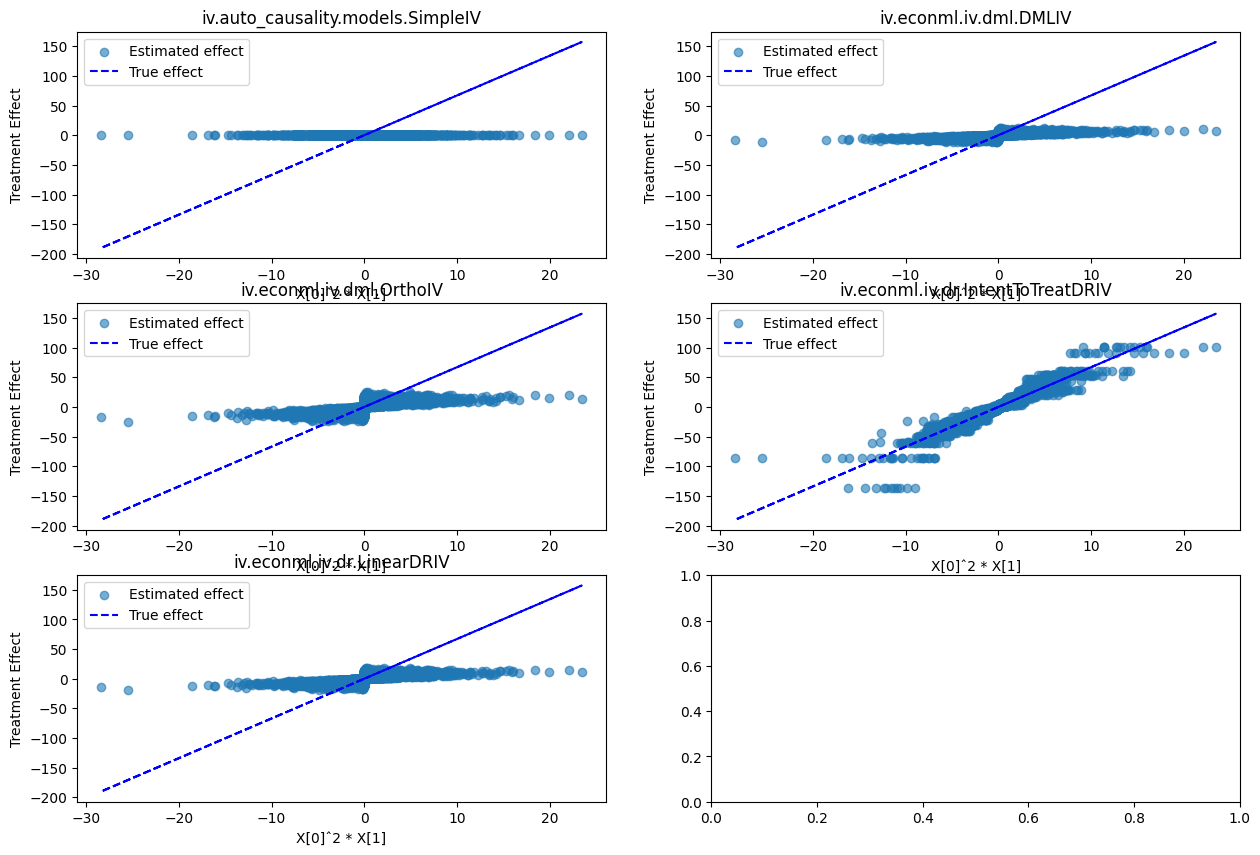

In [166]:
%matplotlib inline

LINEAR_EFFECT_Z = lambda X: TRUE_EFFECT  * ((X.values[:, 0] ** 2) * X.values[:, 1])
excl = [
    'iv.econml.iv.dr.ForestDRIV', 
    'iv.econml.iv.dr.LinearIntentToTreatDRIV',
    'iv.econml.iv.dr.SparseLinearDRIV'
]
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
i, j = 0, 0
for est in ac_linear_te.estimator_list:
    if est not in excl:
        X_test = df_test[features_X[:2]]
        estimator = ac_linear_te.scores[est]['estimator']
        te_pred1 = estimator.estimator.effect(X_test)

        xval = ((X_test.values[:, 0] ** 2) * X_test.values[:, 1])
        ax[i][j].scatter(xval, te_pred1, label="Estimated effect", alpha=0.6)
        ax[i][j].plot(xval, LINEAR_EFFECT_Z(X_test), "b--", label="True effect")
        ax[i][j].set_xlabel("X[0]ˆ2 * X[1]")
        ax[i][j].set_ylabel("Treatment Effect")
        ax[i][j].set_title(est)
        ax[i][j].legend()

        j = (j+1) % 2
        if j == 0:
            i += 1

plt.show()

[Text(0.5, 0, 'MSE(TRUE_CATE, PRED_CATE)'), Text(0, 0.5, 'ENERGY_DISTANCE')]

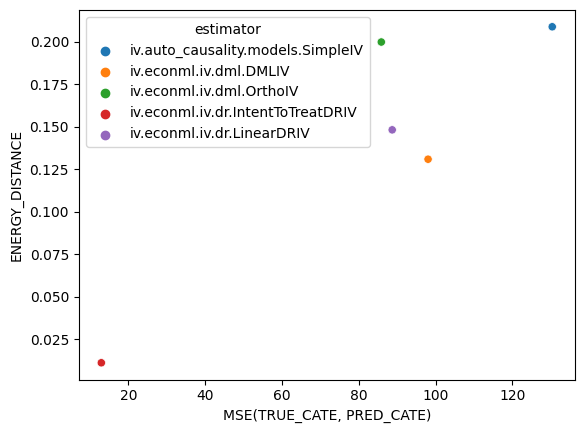

In [146]:
import seaborn as sns

df_stats = pd.DataFrame(stats, columns=["estimator", "mse", "energy_distance"])
g = sns.scatterplot(
    df_stats,
    x="mse",
    y="energy_distance",
    hue="estimator"
)
g.set(xlabel="MSE(TRUE_CATE, PRED_CATE)", ylabel="ENERGY_DISTANCE", title="")

In [64]:
get_est_effects(ac_linear_te, Xtest)

,estimator,estimated_effect,ate_mse,energy_distance
0,iv.auto_causality.models.SimpleIV,0.125123,43.229002,0.208813
1,iv.econml.iv.dml.DMLIV,-0.017493,45.124719,0.130863
2,iv.econml.iv.dml.OrthoIV,-0.086598,46.057914,0.199842
3,iv.econml.iv.dr.IntentToTreatDRIV,-0.026285,45.242911,0.011017
4,iv.econml.iv.dr.LinearDRIV,-0.065063,45.766084,0.148137


In [170]:
!pip install cloudpickle

In [171]:
import cloudpickle


with open("8h_80K_dense.pkl", "wb") as f:
    cloudpickle.dumps(ac_linear_te)

In [172]:
!ls

8h_80K.pkl
8h_80K_dense.pkl
Comparing IV Estimators 2.ipynb
Comparing IV Estimators.ipynb
IV example, with Energy Distance.ipynb
README.md
Random assignment, binary CATE example.ipynb
delete.py
runs
